## Churn Prediction using Logisitic Regression

## Data Dictionary

There are multiple variables in the dataset which can be cleanly divided in 3 categories:

### Demographic information about customers

<b>customer_id</b> - Customer id

<b>vintage</b> - Vintage of the customer with the bank in number of days

<b>age</b> - Age of customer

<b>gender</b> - Gender of customer

<b>dependents</b> - Number of dependents

<b>occupation</b> - Occupation of the customer 

<b>city</b> - City of customer (anonymised)


### Customer Bank Relationship


<b>customer_nw_category</b> - Net worth of customer (3:Low 2:Medium 1:High)

<b>branch_code</b> - Branch Code for customer account

<b>days_since_last_transaction</b> - No of Days Since Last Credit in Last 1 year


### Transactional Information

<b>current_balance</b> - Balance as of today

<b>previous_month_end_balance</b> - End of Month Balance of previous month


<b>average_monthly_balance_prevQ</b> - Average monthly balances (AMB) in Previous Quarter

<b>average_monthly_balance_prevQ2</b> - Average monthly balances (AMB) in previous to previous quarter

<b>current_month_credit</b> - Total Credit Amount current month

<b>previous_month_credit</b> - Total Credit Amount previous month

<b>current_month_debit</b> - Total Debit Amount current month

<b>previous_month_debit</b> - Total Debit Amount previous month

<b>current_month_balance</b> - Average Balance of current month

<b>previous_month_balance</b> - Average Balance of previous month

<b>churn</b> - Average balance of customer falls below minimum balance in the next quarter (1/0)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve, precision_score, recall_score, precision_recall_curve
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
churn_data = pd.read_csv(r'churn_prediction.csv')

In [3]:
churn_data.head()

,customer_id,vintage,age,gender,dependents,occupation,city,customer_nw_category,branch_code,days_since_last_transaction,...,previous_month_end_balance,average_monthly_balance_prevQ,average_monthly_balance_prevQ2,current_month_credit,previous_month_credit,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance,churn
0,1,3135,66,Male,0.0,self_employed,187.0,2,755,224.0,...,1458.71,1458.71,1449.07,0.20,0.20,0.20,0.20,1458.71,1458.71,0
1,2,310,35,Male,0.0,self_employed,NaN,2,3214,60.0,...,8704.66,7799.26,12419.41,0.56,0.56,5486.27,100.56,6496.78,8787.61,0
2,4,2356,31,Male,0.0,salaried,146.0,2,41,NaN,...,5815.29,4910.17,2815.94,0.61,0.61,6046.73,259.23,5006.28,5070.14,0
3,5,478,90,NaN,NaN,self_employed,1020.0,2,582,147.0,...,2291.91,2084.54,1006.54,0.47,0.47,0.47,2143.33,2291.91,1669.79,1
4,6,2531,42,Male,2.0,self_employed,1494.0,3,388,58.0,...,1401.72,1643.31,1871.12,0.33,714.61,588.62,1538.06,1157.15,1677.16,1


In [4]:
churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28382 entries, 0 to 28381
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   customer_id                     28382 non-null  int64  
 1   vintage                         28382 non-null  int64  
 2   age                             28382 non-null  int64  
 3   gender                          27857 non-null  object 
 4   dependents                      25919 non-null  float64
 5   occupation                      28302 non-null  object 
 6   city                            27579 non-null  float64
 7   customer_nw_category            28382 non-null  int64  
 8   branch_code                     28382 non-null  int64  
 9   days_since_last_transaction     25159 non-null  float64
 10  current_balance                 28382 non-null  float64
 11  previous_month_end_balance      28382 non-null  float64
 12  average_monthly_balance_prevQ   

In [5]:
churn_data.describe()

,customer_id,vintage,age,dependents,city,customer_nw_category,branch_code,days_since_last_transaction,current_balance,previous_month_end_balance,average_monthly_balance_prevQ,average_monthly_balance_prevQ2,current_month_credit,previous_month_credit,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance,churn
count,28382.000000,28382.000000,28382.000000,25919.000000,27579.000000,28382.000000,28382.000000,25159.000000,2.838200e+04,2.838200e+04,2.838200e+04,2.838200e+04,2.838200e+04,2.838200e+04,2.838200e+04,2.838200e+04,2.838200e+04,2.838200e+04,28382.000000
mean,15143.508667,2364.336446,48.208336,0.347236,796.109576,2.225530,925.975019,69.997814,7.380552e+03,7.495771e+03,7.496780e+03,7.124209e+03,3.433252e+03,3.261694e+03,3.658745e+03,3.339761e+03,7.451133e+03,7.495177e+03,0.185329
std,8746.454456,1610.124506,17.807163,0.997661,432.872102,0.660443,937.799129,86.341098,4.259871e+04,4.252935e+04,4.172622e+04,4.457581e+04,7.707145e+04,2.968889e+04,5.198542e+04,2.430111e+04,4.203394e+04,4.243198e+04,0.388571
min,1.000000,180.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,-5.503960e+03,-3.149570e+03,1.428690e+03,-1.650610e+04,1.000000e-02,1.000000e-02,1.000000e-02,1.000000e-02,-3.374180e+03,-5.171920e+03,0.000000
25%,7557.250000,1121.000000,36.000000,0.000000,409.000000,2.000000,176.000000,11.000000,1.784470e+03,1.906000e+03,2.180945e+03,1.832507e+03,3.100000e-01,3.300000e-01,4.100000e-01,4.100000e-01,1.996765e+03,2.074408e+03,0.000000
50%,15150.500000,2018.000000,46.000000,0.000000,834.000000,2.000000,572.000000,30.000000,3.281255e+03,3.379915e+03,3.542865e+03,3.359600e+03,6.100000e-01,6.300000e-01,9.193000e+01,1.099600e+02,3.447995e+03,3.465235e+03,0.000000
75%,22706.750000,3176.000000,60.000000,0.000000,1096.000000,3.000000,1440.000000,95.000000,6.635820e+03,6.656535e+03,6.666887e+03,6.517960e+03,7.072725e+02,7.492350e+02,1.360435e+03,1.357553e+03,6.667958e+03,6.654693e+03,0.000000
max,30301.000000,12899.000000,90.000000,52.000000,1649.000000,3.000000,4782.000000,365.000000,5.905904e+06,5.740439e+06,5.700290e+06,5.010170e+06,1.226985e+07,2.361808e+06,7.637857e+06,1.414168e+06,5.778185e+06,5.720144e+06,1.000000


In [6]:
churn_data.churn.value_counts()

0    23122
1     5260
Name: churn, dtype: int64

In [7]:
churn_data.corr()

,customer_id,vintage,age,dependents,city,customer_nw_category,branch_code,days_since_last_transaction,current_balance,previous_month_end_balance,average_monthly_balance_prevQ,average_monthly_balance_prevQ2,current_month_credit,previous_month_credit,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance,churn
customer_id,1.000000,-0.006093,-0.000442,-0.008616,0.000743,0.009618,-0.000286,0.010267,0.006589,0.005819,0.004485,-0.002532,0.002494,-0.006414,0.002603,-0.008760,0.005140,0.004553,-0.002723
vintage,-0.006093,1.000000,0.227390,0.036987,0.044200,-0.167366,-0.380714,-0.088744,0.002986,0.004518,0.003433,0.002244,0.002848,0.028034,0.005406,0.023949,0.001638,0.003448,-0.064637
age,-0.000442,0.227390,1.000000,-0.000612,0.015439,-0.076532,-0.058990,-0.016679,0.054346,0.058342,0.061708,0.059607,0.023840,0.029961,0.027702,0.033296,0.057662,0.060297,-0.020012
dependents,-0.008616,0.036987,-0.000612,1.000000,0.001892,0.013134,0.020141,-0.079834,-0.003070,0.000216,0.001213,0.002949,0.003260,0.025054,0.008207,0.032021,-0.000652,0.001239,0.033487
city,0.000743,0.044200,0.015439,0.001892,1.000000,0.006613,-0.061234,-0.004309,-0.005654,-0.004089,-0.006298,-0.007891,0.004118,0.008087,0.001465,0.005995,-0.005796,-0.005839,-0.001585
customer_nw_category,0.009618,-0.167366,-0.076532,0.013134,0.006613,1.000000,0.235059,0.049531,-0.058314,-0.059854,-0.059535,-0.047010,-0.025254,-0.072374,-0.035917,-0.071721,-0.058648,-0.059113,0.006551
branch_code,-0.000286,-0.380714,-0.058990,0.020141,-0.061234,0.235059,1.000000,0.038708,0.000181,0.000214,0.001955,0.001310,-0.013988,-0.023849,-0.016944,-0.017584,0.001031,0.002080,0.035469
days_since_last_transaction,0.010267,-0.088744,-0.016679,-0.079834,-0.004309,0.049531,0.038708,1.000000,-0.019990,-0.014400,-0.012709,-0.006384,-0.033131,-0.071657,-0.039165,-0.070192,-0.017837,-0.011738,-0.055830
current_balance,0.006589,0.002986,0.054346,-0.003070,-0.005654,-0.058314,0.000181,-0.019990,1.000000,0.947276,0.958307,0.714600,0.030371,0.061754,0.044412,0.081247,0.983412,0.942207,-0.024181
previous_month_end_balance,0.005819,0.004518,0.058342,0.000216,-0.004089,-0.059854,0.000214,-0.014400,0.947276,1.000000,0.970530,0.722998,0.032493,0.114222,0.066329,0.109606,0.974714,0.969605,0.006886


### Treat Missing Values

In [8]:
churn_data.isnull().sum()

customer_id                          0
vintage                              0
age                                  0
gender                             525
dependents                        2463
occupation                          80
city                               803
customer_nw_category                 0
branch_code                          0
days_since_last_transaction       3223
current_balance                      0
previous_month_end_balance           0
average_monthly_balance_prevQ        0
average_monthly_balance_prevQ2       0
current_month_credit                 0
previous_month_credit                0
current_month_debit                  0
previous_month_debit                 0
current_month_balance                0
previous_month_balance               0
churn                                0
dtype: int64

In [9]:
#Dealing with Gender First
churn_data.gender.value_counts()

Male      16548
Female    11309
Name: gender, dtype: int64

In [10]:
#Since both the genders are more or less equally balances, it is difficult to impute the mode. Let us keep the missing values as Unknown
churn_data["gender"].fillna("Unknown", inplace = True) 

In [11]:
#Verifying gender post missing value filling
churn_data.gender.value_counts()

Male       16548
Female     11309
Unknown      525
Name: gender, dtype: int64

In [12]:
#Dealing with dependents next
churn_data.dependents.value_counts()

0.0     21435
2.0      2150
1.0      1395
3.0       701
4.0       179
5.0        41
6.0         8
7.0         3
36.0        1
52.0        1
25.0        1
9.0         1
50.0        1
32.0        1
8.0         1
Name: dependents, dtype: int64

In [13]:
#Since 0 has ~75% of values, let us impute the missing values in this column with mode i.e. 0.0
churn_data["dependents"].fillna(churn_data.dependents.mode().iloc[0], inplace = True)

In [14]:
#Verifying dependents post missing value filling
churn_data.dependents.value_counts()

0.0     23898
2.0      2150
1.0      1395
3.0       701
4.0       179
5.0        41
6.0         8
7.0         3
36.0        1
52.0        1
25.0        1
9.0         1
50.0        1
32.0        1
8.0         1
Name: dependents, dtype: int64

In [15]:
#Dealing with dependents next
churn_data.occupation.value_counts()

self_employed    17476
salaried          6704
student           2058
retired           2024
company             40
Name: occupation, dtype: int64

In [16]:
#Since self_employed has ~50% of values, let us impute the missing values in this column with mode i.e. self_employed
churn_data["occupation"].fillna(churn_data.occupation.mode().iloc[0], inplace = True)

In [17]:
#Verifying dependents post missing value filling
churn_data.occupation.value_counts()

self_employed    17556
salaried          6704
student           2058
retired           2024
company             40
Name: occupation, dtype: int64

In [18]:
#Dealing with days_since_last_transaction next
churn_data.days_since_last_transaction.value_counts()

0.0      1672
3.0       831
14.0      654
4.0       632
6.0       596
         ... 
170.0       1
218.0       1
334.0       1
288.0       1
321.0       1
Name: days_since_last_transaction, Length: 360, dtype: int64

In [19]:
#Since days_since_last_transaction is number of days since last transaction within an year, the days is grater than 365. 
#Hence we can put a very high value such as 999
churn_data["days_since_last_transaction"].fillna(999, inplace = True)

In [20]:
#Verifying days_since_last_transaction post missing value filling
churn_data.days_since_last_transaction.value_counts()

999.0    3223
0.0      1672
3.0       831
14.0      654
4.0       632
         ... 
170.0       1
218.0       1
334.0       1
288.0       1
321.0       1
Name: days_since_last_transaction, Length: 361, dtype: int64

In [21]:
#Dealing with city next
churn_data.city.value_counts()

1020.0    3479
1096.0    2016
409.0     1334
146.0     1291
834.0     1138
          ... 
629.0        1
527.0        1
1212.0       1
530.0        1
70.0         1
Name: city, Length: 1604, dtype: int64

In [22]:
#This has high cardinality. Hence deciding which value to impute is very tough as 803 values are missing. Let us impute a variable -1
churn_data["city"].fillna(-1, inplace = True)

In [23]:
#Verifying city post missing value filling
churn_data.city.value_counts().head(20)

 1020.0    3479
 1096.0    2016
 409.0     1334
 146.0     1291
 834.0     1138
 334.0      930
 1232.0     840
-1.0        803
 623.0      778
 15.0       669
 575.0      631
 1525.0     375
 905.0      345
 491.0      312
 1111.0     312
 1494.0     289
 649.0      281
 1589.0     251
 318.0      245
 1084.0     240
Name: city, dtype: int64

### Handle Outliers

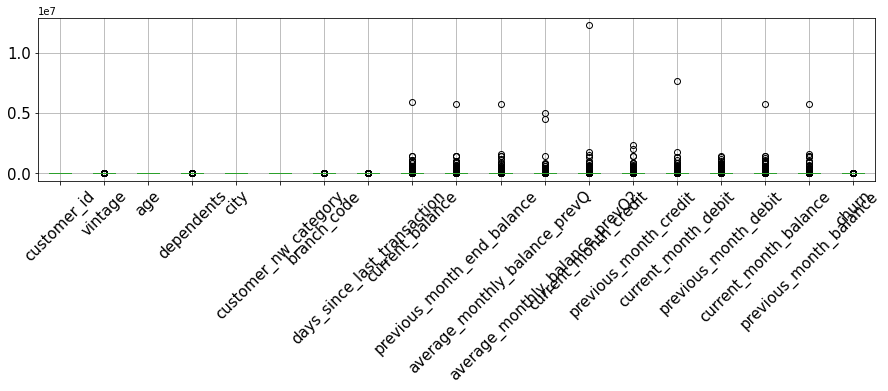

In [25]:
#Let us see the boxplot of churn_data to visualize outliers
churn_data.boxplot(rot=45, fontsize=15, figsize = (15,3))

In [26]:
churn_data.describe()

,customer_id,vintage,age,dependents,city,customer_nw_category,branch_code,days_since_last_transaction,current_balance,previous_month_end_balance,average_monthly_balance_prevQ,average_monthly_balance_prevQ2,current_month_credit,previous_month_credit,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance,churn
count,28382.000000,28382.000000,28382.000000,28382.000000,28382.000000,28382.000000,28382.000000,28382.000000,2.838200e+04,2.838200e+04,2.838200e+04,2.838200e+04,2.838200e+04,2.838200e+04,2.838200e+04,2.838200e+04,2.838200e+04,2.838200e+04,28382.000000
mean,15143.508667,2364.336446,48.208336,0.317102,773.557290,2.225530,925.975019,175.493341,7.380552e+03,7.495771e+03,7.496780e+03,7.124209e+03,3.433252e+03,3.261694e+03,3.658745e+03,3.339761e+03,7.451133e+03,7.495177e+03,0.185329
std,8746.454456,1610.124506,17.807163,0.958386,446.704947,0.660443,937.799129,305.757315,4.259871e+04,4.252935e+04,4.172622e+04,4.457581e+04,7.707145e+04,2.968889e+04,5.198542e+04,2.430111e+04,4.203394e+04,4.243198e+04,0.388571
min,1.000000,180.000000,1.000000,0.000000,-1.000000,1.000000,1.000000,0.000000,-5.503960e+03,-3.149570e+03,1.428690e+03,-1.650610e+04,1.000000e-02,1.000000e-02,1.000000e-02,1.000000e-02,-3.374180e+03,-5.171920e+03,0.000000
25%,7557.250000,1121.000000,36.000000,0.000000,409.000000,2.000000,176.000000,13.000000,1.784470e+03,1.906000e+03,2.180945e+03,1.832507e+03,3.100000e-01,3.300000e-01,4.100000e-01,4.100000e-01,1.996765e+03,2.074408e+03,0.000000
50%,15150.500000,2018.000000,46.000000,0.000000,834.000000,2.000000,572.000000,41.000000,3.281255e+03,3.379915e+03,3.542865e+03,3.359600e+03,6.100000e-01,6.300000e-01,9.193000e+01,1.099600e+02,3.447995e+03,3.465235e+03,0.000000
75%,22706.750000,3176.000000,60.000000,0.000000,1096.000000,3.000000,1440.000000,154.000000,6.635820e+03,6.656535e+03,6.666887e+03,6.517960e+03,7.072725e+02,7.492350e+02,1.360435e+03,1.357553e+03,6.667958e+03,6.654693e+03,0.000000
max,30301.000000,12899.000000,90.000000,52.000000,1649.000000,3.000000,4782.000000,999.000000,5.905904e+06,5.740439e+06,5.700290e+06,5.010170e+06,1.226985e+07,2.361808e+06,7.637857e+06,1.414168e+06,5.778185e+06,5.720144e+06,1.000000


In [27]:
# Create a function to remove values greater than 4*10^6 as seen from above box plot. we have very few values
def remove_outlier(df, col_list):
    for col in col_list:
        print(df.shape , col)
        df = df[df[col]<4000000]
    return df

col_list = ["current_balance", "previous_month_end_balance", "average_monthly_balance_prevQ", "average_monthly_balance_prevQ2", "current_month_credit", "current_month_debit", "current_month_balance", "previous_month_balance"]
churn_data_outlier_treated = remove_outlier(churn_data , col_list)

(28382, 21) current_balance
(28381, 21) previous_month_end_balance
(28381, 21) average_monthly_balance_prevQ
(28381, 21) average_monthly_balance_prevQ2
(28380, 21) current_month_credit
(28379, 21) current_month_debit
(28379, 21) current_month_balance
(28379, 21) previous_month_balance


In [28]:
churn_data_outlier_treated.shape

(28379, 21)

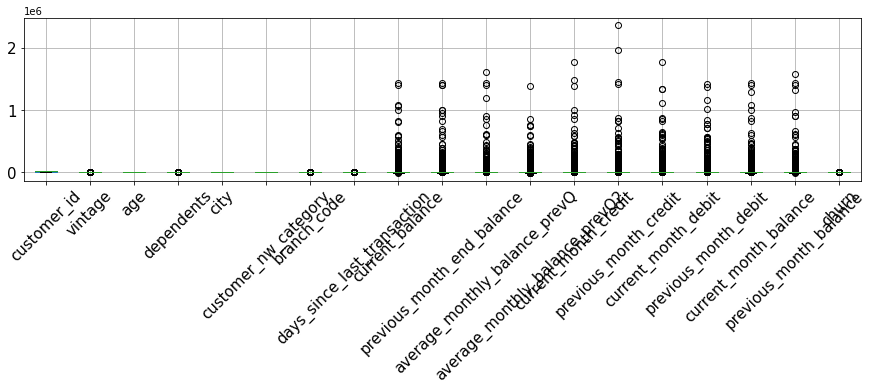

In [29]:
#Let us see the boxplot of churn_data to visualize outliers
churn_data_outlier_treated.boxplot(rot=45, fontsize=15, figsize = (15,3))

In [30]:
churn_data_outlier_treated[(churn_data_outlier_treated.age<18)&(churn_data_outlier_treated.occupation!="student")]

,customer_id,vintage,age,gender,dependents,occupation,city,customer_nw_category,branch_code,days_since_last_transaction,...,previous_month_end_balance,average_monthly_balance_prevQ,average_monthly_balance_prevQ2,current_month_credit,previous_month_credit,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance,churn
1034,1105,1063,13,Female,0.0,self_employed,382.0,2,785,7.0,...,3265.71,2455.42,7065.56,571.84,0.41,0.41,0.41,2787.11,2497.91,0
1929,2066,2942,16,Female,0.0,self_employed,905.0,2,1336,999.0,...,5136.99,5136.99,5104.45,0.57,0.57,0.57,0.57,5136.99,5136.99,0
2095,2242,453,6,Female,0.0,self_employed,1020.0,3,990,336.0,...,1726.30,1707.62,1599.53,0.66,0.66,0.66,0.66,1726.30,1716.09,0
2642,2815,824,1,Unknown,0.0,self_employed,834.0,2,1224,55.0,...,4832.03,4016.55,4303.31,0.69,2140.04,64.97,0.69,4800.99,4555.98,1
2685,2861,5360,15,Male,0.0,self_employed,630.0,2,36,999.0,...,1659.42,1659.42,1648.91,0.14,0.14,0.14,0.14,1659.42,1659.42,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26024,27781,208,12,Male,0.0,salaried,409.0,2,272,47.0,...,24105.39,22086.24,14534.48,0.69,4286.40,0.69,0.69,24129.53,22317.84,0
26154,27925,4972,17,Female,0.0,self_employed,1020.0,3,118,43.0,...,542.98,1608.68,97.99,0.07,15444.43,0.07,15000.07,542.84,4184.60,1
27238,29082,2459,10,Female,0.0,self_employed,623.0,2,81,73.0,...,2076.07,1709.76,505.39,0.16,0.16,0.16,0.16,2040.35,2076.07,0
27742,29615,929,5,Male,0.0,self_employed,146.0,2,542,999.0,...,2832.06,2832.06,1553.55,0.21,0.21,0.21,0.21,2832.06,2832.06,0


In [31]:
#for people less than 18, they cannot be salaried or selfemployed as stated. Hence they are outliers
churn_data_outlier_treated1 = churn_data_outlier_treated.drop(churn_data_outlier_treated[(churn_data_outlier_treated.age<18) & (churn_data_outlier_treated.occupation!="student")].index)

In [32]:
churn_data_outlier_treated1.shape

(28315, 21)

In [33]:
#People with dependents greater than 10 are very few cases. They could be outliers or extreme cases. However they can be dropped
churn_data_outlier_treated = churn_data_outlier_treated1.drop(churn_data_outlier_treated1[churn_data_outlier_treated1.dependents>10].index)

In [34]:
churn_data_outlier_treated.shape

(28310, 21)

In [35]:
churn_data_outlier_treated.dependents.value_counts()

0.0    23831
2.0     2150
1.0     1395
3.0      701
4.0      179
5.0       41
6.0        8
7.0        3
9.0        1
8.0        1
Name: dependents, dtype: int64

### Drop unnecessary columns

In [36]:
churn_data_outlier_treated.reset_index(drop=True,inplace=True)

In [37]:
len(churn_data_outlier_treated.city.unique())

1604

In [38]:
len(churn_data_outlier_treated.customer_id.unique())

28310

In [39]:
len(churn_data_outlier_treated.branch_code.unique())

3185

In [40]:
# Customer_id has high cardinality, hence dropping it
# City and branch_code having numbers would mean they have quantitative relationship which is wrong. Hence dropping them
churn_data_final = churn_data_outlier_treated.drop(["customer_id", "city", "branch_code"], axis=1)

In [41]:
churn_data_final.shape

(28310, 18)

In [42]:
churn_data_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28310 entries, 0 to 28309
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   vintage                         28310 non-null  int64  
 1   age                             28310 non-null  int64  
 2   gender                          28310 non-null  object 
 3   dependents                      28310 non-null  float64
 4   occupation                      28310 non-null  object 
 5   customer_nw_category            28310 non-null  int64  
 6   days_since_last_transaction     28310 non-null  float64
 7   current_balance                 28310 non-null  float64
 8   previous_month_end_balance      28310 non-null  float64
 9   average_monthly_balance_prevQ   28310 non-null  float64
 10  average_monthly_balance_prevQ2  28310 non-null  float64
 11  current_month_credit            28310 non-null  float64
 12  previous_month_credit           

### Encoding

#### We have two object class. Let's encode them using get_dummies

In [43]:
churn_data_final = pd.concat([pd.get_dummies(churn_data_final.gender, drop_first=True),churn_data_final],axis=1)

In [44]:
churn_data_final = pd.concat([pd.get_dummies(churn_data_final.occupation, drop_first=True),churn_data_final],axis=1)

In [45]:
churn_data_final

,retired,salaried,self_employed,student,Male,Unknown,vintage,age,gender,dependents,...,previous_month_end_balance,average_monthly_balance_prevQ,average_monthly_balance_prevQ2,current_month_credit,previous_month_credit,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance,churn
0,0,0,1,0,1,0,3135,66,Male,0.0,...,1458.71,1458.71,1449.07,0.20,0.20,0.20,0.20,1458.71,1458.71,0
1,0,0,1,0,1,0,310,35,Male,0.0,...,8704.66,7799.26,12419.41,0.56,0.56,5486.27,100.56,6496.78,8787.61,0
2,0,1,0,0,1,0,2356,31,Male,0.0,...,5815.29,4910.17,2815.94,0.61,0.61,6046.73,259.23,5006.28,5070.14,0
3,0,0,1,0,0,1,478,90,Unknown,0.0,...,2291.91,2084.54,1006.54,0.47,0.47,0.47,2143.33,2291.91,1669.79,1
4,0,0,1,0,1,0,2531,42,Male,2.0,...,1401.72,1643.31,1871.12,0.33,714.61,588.62,1538.06,1157.15,1677.16,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28305,0,0,0,1,0,0,1845,10,Female,0.0,...,1076.43,2282.19,2787.70,0.30,0.30,0.30,0.30,1076.43,1076.43,0
28306,0,0,1,0,0,0,4919,34,Female,0.0,...,4069.21,3668.83,3865.55,1.71,2.29,901.00,1014.07,3738.54,3690.32,0
28307,0,1,0,0,1,0,297,47,Male,0.0,...,61017.55,53444.81,21925.81,4666.84,3883.06,168.23,71.80,61078.50,57564.24,1
28308,0,0,1,0,1,0,2585,50,Male,3.0,...,1625.55,1683.20,1857.42,0.20,0.20,0.20,0.20,1625.55,1625.55,0


In [46]:
#We dont need the old columns of gender and occupation anymore
churn_data_final.drop(["gender","occupation"], axis=1, inplace= True)

In [47]:
#Let's see the final dataframe before starting the modelling
churn_data_final

,retired,salaried,self_employed,student,Male,Unknown,vintage,age,dependents,customer_nw_category,...,previous_month_end_balance,average_monthly_balance_prevQ,average_monthly_balance_prevQ2,current_month_credit,previous_month_credit,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance,churn
0,0,0,1,0,1,0,3135,66,0.0,2,...,1458.71,1458.71,1449.07,0.20,0.20,0.20,0.20,1458.71,1458.71,0
1,0,0,1,0,1,0,310,35,0.0,2,...,8704.66,7799.26,12419.41,0.56,0.56,5486.27,100.56,6496.78,8787.61,0
2,0,1,0,0,1,0,2356,31,0.0,2,...,5815.29,4910.17,2815.94,0.61,0.61,6046.73,259.23,5006.28,5070.14,0
3,0,0,1,0,0,1,478,90,0.0,2,...,2291.91,2084.54,1006.54,0.47,0.47,0.47,2143.33,2291.91,1669.79,1
4,0,0,1,0,1,0,2531,42,2.0,3,...,1401.72,1643.31,1871.12,0.33,714.61,588.62,1538.06,1157.15,1677.16,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28305,0,0,0,1,0,0,1845,10,0.0,2,...,1076.43,2282.19,2787.70,0.30,0.30,0.30,0.30,1076.43,1076.43,0
28306,0,0,1,0,0,0,4919,34,0.0,2,...,4069.21,3668.83,3865.55,1.71,2.29,901.00,1014.07,3738.54,3690.32,0
28307,0,1,0,0,1,0,297,47,0.0,2,...,61017.55,53444.81,21925.81,4666.84,3883.06,168.23,71.80,61078.50,57564.24,1
28308,0,0,1,0,1,0,2585,50,3.0,3,...,1625.55,1683.20,1857.42,0.20,0.20,0.20,0.20,1625.55,1625.55,0


### Start modelling process

In [48]:
X = churn_data_final.drop(["churn"], axis=1)
y = churn_data_final.churn

### Splitting the data

In [49]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=55,test_size=0.25)

Base model

In [50]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score

dtc_base = DecisionTreeClassifier(random_state=1)
dtc_base.fit(X_train, y_train)
y_pred_dtc = dtc_base.predict(X_test)
y_pred_train_dtc = dtc_base.predict(X_train)
print(accuracy_score(y_pred_train_dtc, y_train))
print(accuracy_score(y_pred_dtc, y_test))

1.0
0.7925967787510596


#### Metric which is more important than accuracy is recall as we are more concerned with False Negative

In [51]:
print(recall_score(y_train, dtc_base.predict(X_train)))
print(recall_score(y_test, dtc_base.predict(X_test)))

1.0
0.4660564454614798


#### The base model is clearly overfitting

### Decision Tree with hyper parameter tuning manually

In [52]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(criterion='entropy', max_depth=15, random_state=1, max_features=None)
dtc.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=15, random_state=1)

In [53]:
dtc.score(X_train,y_train)

0.9584118311981914

In [54]:
dtc.score(X_test,y_test)

0.8218423283413394

In [55]:
from sklearn.metrics import recall_score

print(recall_score(y_train, dtc.predict(X_train)))
print(recall_score(y_test, dtc.predict(X_test)))

0.8063040162684291
0.448512585812357


### Decision Tree with hyper parameter tuning using Grid Search CV

In [56]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

dtclassifier = DecisionTreeClassifier()


tree_para = [{'criterion':['gini','entropy'],'max_depth': [9,10,11,12,13,14,15,16,17],
                             'max_features': ['sqrt', 'log2', None], 'random_state' : [0]}]
                            
grid_search_model = GridSearchCV(dtclassifier,tree_para, scoring = 'recall', n_jobs = -1)

In [57]:
grid_search_model.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_depth': [9, 10, 11, 12, 13, 14, 15, 16, 17],
                          'max_features': ['sqrt', 'log2', None],
                          'random_state': [0]}],
             scoring='recall')

In [58]:
grid_search_model.best_params_

{'criterion': 'gini', 'max_depth': 17, 'max_features': None, 'random_state': 0}

In [59]:
print(recall_score(y_train, grid_search_model.predict(X_train)))
print(recall_score(y_test, grid_search_model.predict(X_test)))

0.8088459583121504
0.4439359267734554


#### Recall is currently at 44%. Grid search has chosen the best parameters to achieve the highest recall along with cross validation. But we can still see overfitting as there is lot of distinction between train recall and test recall

### Random Forest - Let's see if this can improve the recall

In [60]:
#Creating base model
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=0)

rfc.fit(X_train,y_train)

RandomForestClassifier(random_state=0)

In [61]:
rfc.score(X_train,y_train)

1.0

In [62]:
rfc.score(X_test,y_test)

0.8660638598474145

In [63]:
print(recall_score(y_train, rfc.predict(X_train)))
print(recall_score(y_test, rfc.predict(X_test)))

1.0
0.4439359267734554


#### Recall is showing at 44%. But its clearly overfitting

### Using random Search

In [64]:
from sklearn.model_selection import RandomizedSearchCV
model_rf = RandomForestClassifier(random_state = 0)
param_dist = [{"max_depth": range(10,18),
              "bootstrap": [True,False],
              "n_estimators": [100,200],
              "criterion" : ["gini", "entropy"],
              'max_features': ['sqrt', 'log2',5]
             }]
# run randomized search
n_iter_search = 20
model_rf_tuned = RandomizedSearchCV(model_rf, param_distributions = param_dist,
                                   n_iter = n_iter_search,
                                   n_jobs = -1)

In [65]:
model_rf_tuned.fit(X_train,y_train)

RandomizedSearchCV(estimator=RandomForestClassifier(random_state=0), n_iter=20,
                   n_jobs=-1,
                   param_distributions=[{'bootstrap': [True, False],
                                         'criterion': ['gini', 'entropy'],
                                         'max_depth': range(10, 18),
                                         'max_features': ['sqrt', 'log2', 5],
                                         'n_estimators': [100, 200]}])

In [66]:
model_rf_tuned.best_params_

{'n_estimators': 100,
 'max_features': 5,
 'max_depth': 16,
 'criterion': 'gini',
 'bootstrap': True}

In [67]:
print(recall_score(y_train, model_rf_tuned.predict(X_train)))
print(recall_score(y_test, model_rf_tuned.predict(X_test)))

0.7498729028978139
0.4469870327993898


#### Even though recall is almost same as the base model of RF, we need to keep 2 things in mind
##### 1) Base model was not cross validated 2) This is a better model as base model was clearly overfitting

#### Let us finalize this model as this is less overfitting as compared to GridSearchCV model

In [68]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix = pd.DataFrame(confusion_matrix(y_test, model_rf_tuned.predict(X_test)))
def log():
    # provide confusion matrix index name as['Actual No_Deposit','Actual Deposit']
    confusion_matrix.index = ['Actual No_Churn','Actual Churn']
    # provide confusion matrix index name as['Predicted No_Deposit','Predicted Deposit']
    confusion_matrix.columns = ['Predicted No_Churn','Predicted Churn']
    print(confusion_matrix)
log()

                 Predicted No_Churn  Predicted Churn
Actual No_Churn                5544              223
Actual Churn                    725              586


### Using the best params, let us try to reduce the classification threshold to see if the recall improves

In [69]:
y_pred_train_rf_tune = model_rf_tuned.predict_proba(X_train)
y_pred_test_rf_tune = model_rf_tuned.predict_proba(X_test)

In [70]:
y_pred_train_rf_tune

array([[0.95888862, 0.04111138],
       [0.93874813, 0.06125187],
       [0.94216346, 0.05783654],
       ...,
       [0.77020362, 0.22979638],
       [0.92120821, 0.07879179],
       [0.90249655, 0.09750345]])

In [71]:
from sklearn.metrics import precision_score
import numpy as np
def log():
    for t in np.linspace(0,1,11):
        # calculate and print the accuracy using the above mentioned threshold probability
        preds1 = np.where(y_pred_test_rf_tune[:,0]>= t,0,1)
        print("-------------",t,"---------")
        print('Accuracy score for test data is:', accuracy_score(y_test,preds1))
        print('Recall score for test data is:', recall_score(y_test,preds1))
        print('Precision score for test data is:', precision_score(y_test,preds1))
    return preds1
preds1 = log()

------------- 0.0 ---------
Accuracy score for test data is: 0.8147781859282283
Recall score for test data is: 0.0
Precision score for test data is: 0.0
------------- 0.1 ---------
Accuracy score for test data is: 0.8174625600452106
Recall score for test data is: 0.015255530129672006
Precision score for test data is: 0.9523809523809523
------------- 0.2 ---------
Accuracy score for test data is: 0.8301780163888104
Recall score for test data is: 0.10068649885583524
Precision score for test data is: 0.8516129032258064
------------- 0.30000000000000004 ---------
Accuracy score for test data is: 0.8467081096354903
Recall score for test data is: 0.2212051868802441
Precision score for test data is: 0.8192090395480226
------------- 0.4 ---------
Accuracy score for test data is: 0.8592822831308279
Recall score for test data is: 0.34172387490465295
Precision score for test data is: 0.7710843373493976
------------- 0.5 ---------
Accuracy score for test data is: 0.8660638598474145
Recall score fo

#### Clearly we can see that recall can be as high as we want but it will come at a cost of low precision. We will get lot of false positive and for those customers we would be wasting our energy trying to stop them from churning. Hence, now its a business decision to decide the threshold and see what is the recall they want and what is the cost they are ready to accept.

#### If required, a general threshold could be 0.8, which gives good recall of 0.72, good accuracy of 0.8 and decent precision of 0.5

### It is also important to see the AUC ROC curve which indicates how good our model is to differentiate between classes for the above threshold of 0.8

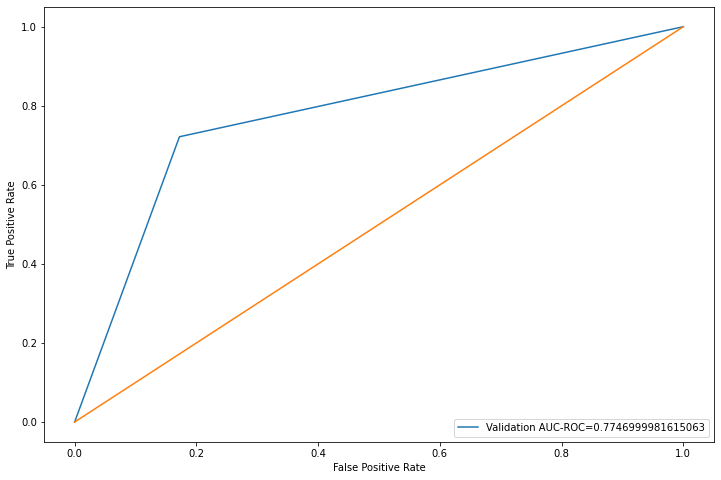

In [72]:
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test,np.where(y_pred_test_rf_tune[:,0]>= 0.8,0,1)) 
auc = roc_auc_score(y_test, np.where(y_pred_test_rf_tune[:,0]>= 0.8,0,1)) 
plt.figure(figsize=(12,8)) 
plt.plot(fpr,tpr,label="Validation AUC-ROC="+str(auc)) 
x = np.linspace(0, 1, 1000)
plt.plot(x, x, linestyle='-')
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.legend(loc=4) 
plt.show()

### We have a pretty decent AUC-ROC value of 0.78. We can use this model of random forest with hyperparameters 
'n_estimators': 100,
 'max_features': 'sqrt',
 'max_depth': 12,
 'criterion': 'entropy',
 'bootstrap': True
 
### Threshold for classifying would be 0.8 instead of the default 0.5